## 1. Analyze A/B Test Results


## 2. Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## 3. Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, the results of an A/B test run by an e-commerce website has been analyzed. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision."


<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.




In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

## `1.` Read the csv file and find the conversion ratio

### 1-a. Read in the dataset and take a look at the top few rows

In [2]:
#Reading the dataset and looing at the top few rows
df= pd.read_csv('C:\\Users\\raz37388\\Desktop\\Udacity_assignment\\Assignment 3\\Assignment File\\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### 1- b. Use the below cell to find the number of rows in the dataset

In [3]:
# shape of the dataset
df.shape

(294478, 5)

### 1- c. The number of unique users in the dataset

In [4]:
#number of unique users in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
#duplicate values-- returns 0 if there is none
df[df.duplicated()].count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
#duplicate values-- should return False if there is none
df.duplicated().any()

False

In [7]:
# summary of the dataframe and the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
#first few lines of the dataframe 
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### 1- d. The proportion of users converted

In [9]:
#proportion of users converted
df['converted'].mean()

0.11965919355605512

### 1- e. The number of times the `new_page` and `treatment` don't line up

In [10]:
#calculate te number of times the `new_page` and `treatment` don't line up.
mismatch = df.query('landing_page== "new_page" & group == "control"').count()+ df.query('landing_page == "old_page" & group == "treatment"').count()

#show the mismatch
mismatch[0]

3893

### 1- f. Do any of the rows have missing values?

In [11]:
#chcking rows with missing values- return 0 if there is none
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [12]:
#chcking rows with missing values- should return False since there is none
df.isnull().sum().any()

False

## 2. New Dataframe with mismatch pages

* Note: For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Hence, these pages with mismatch needs to be excluded and a new dataframe needs to be created.

In [13]:
# Separating the control and treatment page 
df2_control = df.query('group == "control" & landing_page == "old_page"')
df2_treatment = df.query('group == "treatment" & landing_page == "new_page"')

In [14]:
# Counting the total number of  control and treatment page without any mismatch
df2_control_count = df.query('group == "control" & landing_page == "old_page"').count()[0]
df2_treatment_count = df.query('group == "treatment" & landing_page == "new_page"').count()[0]

# Adding the total mismatch
total_count = df2_control_count + df2_treatment_count

# Show the total mismatch
total_count

290585

In [15]:
#subtructing the total number of  control and treatment page from the total page to find the mismatch
# should return the same number of mistmach-3893
df.shape[0]- total_count

3893

In [16]:
# View the control page
df2_control.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [17]:
# View the treatment page
df2_treatment.head(3)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1


In [18]:
# combining the control and treatment dataframe 
df2 = df2_control.combine_first(df2_treatment)
df2.shape

(290585, 5)

In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

# `3.` Users details

### 3-a. How many unique **user_id**s are in **df2?**

In [20]:
# unique user_ids are in df2
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

### 3-b. There is one **user_id** repeated in df2.  What is it?

In [21]:
# Find the duplicate userid
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


### 3-c. What is the row information for the repeat user_id?

In [22]:
#View the instances of the duplicate userid
df2.query('user_id == 773192.0' )

,user_id,timestamp,group,landing_page,converted
1899,773192.0,2017-01-09 05:37:58.781806,treatment,new_page,0.0
2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


### 3-d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as df2.

In [23]:
# drop columns from the dataset that will not be used during the analysis-- keep the first of the duplicates
df2 = df2.drop_duplicates(['user_id'], keep = 'first')

In [24]:
#checking for duplicate value- should return False after the removal of the duplicate value
df2.duplicated().any()

False

In [25]:
#checking how many times the duplicate item is present
df2.query('user_id == 773192.0' )

,user_id,timestamp,group,landing_page,converted
1899,773192.0,2017-01-09 05:37:58.781806,treatment,new_page,0.0


In [26]:
# Dimension of df2
df2.shape

(290584, 5)

## 4. Individual Conversion

### 4-a. What is the probability of an individual converting regardless of the page they receive?

In [27]:
# First few rows of the dataframe df2
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0


In [28]:
# Last few rows of the dataframe df2
df2.tail(5)

,user_id,timestamp,group,landing_page,converted
294473,751197.0,2017-01-03 22:28:38.630509,control,old_page,0.0
294474,945152.0,2017-01-12 00:51:57.078372,control,old_page,0.0
294475,734608.0,2017-01-22 11:45:03.439544,control,old_page,0.0
294476,697314.0,2017-01-15 01:20:28.957438,control,old_page,0.0
294477,715931.0,2017-01-16 12:40:24.467417,treatment,new_page,0.0


In [29]:
# probability of converting 
df2['converted'].mean()

0.11959708724499628

### 4-b. Given that an individual was in the `control` group, what is the probability they converted?

In [30]:
#separating the control and the treatment group from df2
df2_control = df2.query('group == "control"')
df2_treatment = df2.query('group == "treatment"')

In [31]:
# Counting the control and the treatment group 
control_group_count = df2_control.count()[0]
treatment_group_count = df2_treatment.count()[0]

# Adding the Control and the treatment group- should return the total number of unique values- 290584
total = control_group_count + treatment_group_count

# View the total count
total 

290584

In [32]:
# Print the number of id in the control and the treatment group
print("Number of id in the control group: {}".format(control_group_count))
print("Number of id in the treatment group: {}".format(treatment_group_count))

Number of id in the control group: 145274
Number of id in the treatment group: 145310


In [33]:
# Count and print the number of id in the control and treatment group

converted_control = df2.query('group == "control" & converted == 1').count()[0]
converted_treatment = df2.query('group == "treatment" & converted == 1').count()[0]

print("Number of converted id in the control group: {}".format(converted_control))
print("Number of converted id in the treatment group: {}".format(converted_treatment))


Number of converted id in the control group: 17489
Number of converted id in the treatment group: 17264


In [34]:
#Count the conversion rate for the treatment and the control page

control_conversion_rate = converted_control / control_group_count
treatment_conversion_rate = converted_treatment / treatment_group_count

print("Conversion rate for the control group: {}".format(control_conversion_rate))
print("Conversion rate for the control group: {}".format( treatment_conversion_rate))

Conversion rate for the control group: 0.1203863045004612
Conversion rate for the control group: 0.11880806551510564


In [35]:
# probability of converting from the control group
df2_control['converted'].mean()

0.1203863045004612

### 4-c. Given that an individual was in the `treatment` group, what is the probability they converted?**

In [36]:
# probability of conversion in the treatment group
df2_treatment['converted'].mean()

0.11880806551510564

In [37]:
#difference of mean between the treatment and the control group conversion 
obs_diff = df2_treatment['converted'].mean() - df2_control['converted'].mean() 
obs_diff

-0.0015782389853555567

### 4-d. What is the probability that an individual received the new page?**

In [38]:
# probability that an individual received the old page
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

In [39]:
# probability that an individual received the old page
df2.query('landing_page == "old_page"').count()[0]/df2.shape[0]

0.4999380557773312

**e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.**

### 4-e. Observations

**1.** The number of id in the control group is not exactly the same as the number of id in the treatment group. Hence, we have calculated the conversion rate (which is same as the probability) and it can be said that the control group has a slightly higher probability of conversion than the treatment group.


**2.** Because, we only have the unique id's in the dataframe df2, the idea of conversion rate is same as the click throught rate. 

<a id='ab_test'></a>
### Part II - A/B Test


* For now, we consider that we need to make the decision just based on all the data provided. We will state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### 5-a. Defining Null & Alternative Hypothesis

### Null Hypothesis: The treatment has no effect on  conversion, that is the probability of conversion before treatment , **$p_{old}$** is same or even higher than the probability of conversion after the treatment,  **$p_{new}$** 

### Alternative Hypothesis: The new homepage design has a higher conversion rate than the old homepage design, that is **$p_{new}$** > **$p_{old}$**

* We assmume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.** <br><br>

* We will use a sample size for each page equal to the ones in **ab_data.csv**.**  <br><br>

* We shall perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.**  <br><br>

### 5-b.  What is the **convert rate** for $p_{new}$ under the null?**

***The null hypothesis states that there is no difference in conversion based on the page, which means the conversions for each page are the same. Hence, the probability of the new and the old pages are the same. ***

In [40]:
p_null= df2['converted'].mean()
p_new = p_null
p_new 

0.11959708724499628

### 5-c.  What is the **convert rate** for $p_{old}$ under the null?

In [41]:
p_old = p_null
p_old

0.11959708724499628

### 5-d.  What is $n_{new}$?

In [42]:
# number of landing id in the new page
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new 

145310

### 5-e.  What is $n_{old}$?

In [43]:
# number of landing id in the old page
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old 

145274

### 5-f.  Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.**

In [44]:
new_page_converted = np.random.choice([0, 1], size= n_new, p=[(1 - p_null), p_null])

### 5-g.  Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.**

In [45]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_null), p_null])

### 5-h. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).**

In [46]:
p_new = new_page_converted.mean()
p_new

0.11946184020370243

In [47]:
p_old = old_page_converted.mean()
p_old

0.11926428679598551

In [48]:
p_new - p_old

0.00019755340771691887

### 5-i.  Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.**

In [49]:
# Bootstarping samples to compute the differecne of mean
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_null), p_null])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_null), p_null])
    p_new = new_page_converted.mean()
    p_old = old_page_converted.mean()
    p_diffs.append(p_new-p_old )

In [50]:
# Converting the diff values into an array
p_diffs = np.array(p_diffs)

### 5-j.  Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.**

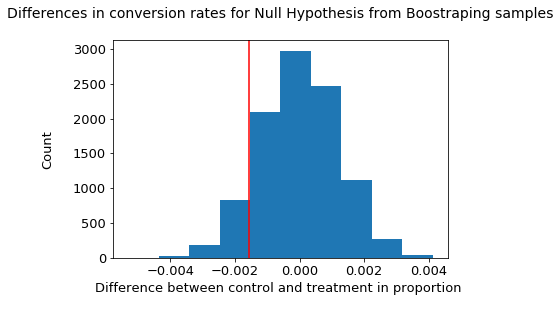

In [100]:
# plotting a histogram of the p_diffs and marking the observed diff in the histogram
plt.hist(p_diffs)
plt.axvline(obs_diff, c = 'red')
plt.title("Differences in conversion rates for Null Hypothesis from Boostraping samples\n",fontsize=14)
plt.xlabel("Difference between control and treatment in proportion \n", fontsize=13)
plt.ylabel("Count\n", fontsize=13)
plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

### 5-k.  What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?**

In [52]:
# proportion of the p_diffs are greater than the actual difference 
(p_diffs > obs_diff).mean()

0.9036

### 5-l  In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?**

**1. The value computed in part j is called the p-value.** 

**2. The p-value calculates the probability  observing the statistic (in favor of the alternative) if the null hypothesis is true.*** 

**3.When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null. By comparing our p-value to our type I error threshold (**α**),we can make our decision about which hypothesis we will choose. As we can see our p-value is far greater than theType I error rate of 5% (p-value of 0.05), we can conclude that we fail to reject the null hypothesis and therefore we do not have sufficient evidence to conclude that the new page is better than the old page when it comes to the conversion rate..**



**l. Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.**

In [53]:
# first few rows of df2
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0


In [54]:
# last few rows of df2
df2.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197.0,2017-01-03 22:28:38.630509,control,old_page,0.0
294474,945152.0,2017-01-12 00:51:57.078372,control,old_page,0.0
294475,734608.0,2017-01-22 11:45:03.439544,control,old_page,0.0
294476,697314.0,2017-01-15 01:20:28.957438,control,old_page,0.0
294477,715931.0,2017-01-16 12:40:24.467417,treatment,new_page,0.0


In [55]:
# counting the the number of converted page for the control group
convert_old = df2.query('landing_page == "old_page" & converted == 1.0').count()[0]

# the number of page in the control group
n_old = df2.query('landing_page == "old_page"').count()[0]

#counting the the number of converted page for the treatment group
convert_new = df2.query('landing_page == "new_page" & converted == 1.0').count()[0]

# the number of page in the treatment group
n_new = df2.query('landing_page == "new_page"').count()[0]

convert_old, convert_new, n_new, n_old

(17489, 17264, 145310, 145274)

**m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.**

**This is a one-tailed test as the alternative hypothesis states that the treatment page will have a better conversion rate. For a 95% interval, the alpha value is 0.05 (1-0.95). For this alpha level, we can calculate the Z_critical value and the significance level using builtin function from the statsmodels.api library.**

In [56]:
#computing z and p values
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

In [57]:
# Calculating Z_critical value and the show the signnificance level
from scipy.stats import norm
Z_critical = norm.ppf(1-0.05)

significance = norm.cdf(Z_critical)
# 0.9999999383005862 # Tells us how significant our z-score i

Z_critical, significance 

(1.6448536269514722, 0.95)

**n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?**

*** 1. The p value calculated with the z-score closely matches the value calcuated from the bootstraping samples.*** 

** 2. Since the z-score of -1.30 does not exceed the critical value of 1.6448536269514722, we fail to reject the null hypothesis . Hence, we can say with a certainty of 95% that the new page is not better than the old page when it comes to converstion rate.***

<a id='regression'></a>
### Part III - A regression approach

****`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?**

***In logistic regression, we deal with the possibilites one of an event happpening and not happening- conversion or not in this case. Hence we should do logistic regression here.***

**b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.**

In [58]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0


In [59]:
# adding intercept 
df2['intercept'] =1

In [60]:
#creating the dummy variables
df2[['ab_2', 'ab_page']] = pd.get_dummies(df['group'])

In [61]:
# vizualize the dummy variables column in the dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_2,ab_page
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,1,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,1,0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,0,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,0,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,1,0


In [62]:
#drop one of the dummy variables column
df2 = df2.drop(['ab_2'], axis= 1)

In [63]:
# See the dataframe after one the dummy variables column is dropped
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [64]:
#Creating statsmodels and performt the logistic regression
df2['intercept'] =1
logit_mode = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results=logit_mode.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:39:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

***Note: ab_page is not statistically significant to predict the conversion as it has a p value greater than 0.05.***

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  

In [65]:
#computing z and p values for a two sided test
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')

(-1.3109241984234394, 0.18988337448195103)

**1. The p-value associated with ab_page is -1.312..**

**2. It differs from the analysis we did in part II because, there we performed a one-sided test, where as in this case with the logistic regression, we have performed a two-sided test.**

** 3. If we compute the z and p value for a two-sided test we find a p value that is very close.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Advantage: We can include other variables in our data to predict individual converts. Also, we can include higher order term like quadratics, cubics, interactions etc.. These alternatives can help us fit more complex relationships in the data and help us understand the idea of how the other parameters influence the individual conversion.***

**However, this process of including other parameters is not without challenges.** 

**Disadvantage:**

**1. The inclusion of higher order terms takeaway the ease of interpreting coefficients.**

**2. We want our predictor variables not to be related to each other. Multicollinearity is when we have predictor variables that are correlated with one another. As we include other variables, in general, we need to be aware of multicollinearity as it can lead us  to coefficients being flipped from the direction we expect from simple linear regression.**

**3. Inclusion of more factor can sometime imbalance in the population represented in each group can lead to situations like Simpson's Paradox.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [66]:
# reading the csv file
df_countries = pd.read_csv('C:\\Users\\raz37388\\Desktop\\Udacity_assignment\\Assignment 3\\Assignment File\\countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [67]:
# Summary of the dataframe with data types and null values
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [68]:
# number of countries in the dataframe
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [69]:
#first few columns of dataframe df2
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0


In [70]:
# merging the df2 with df_countries making a new dataframe
df3 = pd.merge(df2, df_countries, on='user_id', how='left')
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US
5,936923.0,2017-01-10 15:20:49.083499,control,old_page,0.0,1,0,US
6,679687.0,2017-01-19 03:26:46.940749,treatment,new_page,1.0,1,1,CA
7,719014.0,2017-01-17 01:48:29.539573,control,old_page,0.0,1,0,US
8,817355.0,2017-01-04 17:58:08.979471,treatment,new_page,1.0,1,1,UK
9,839785.0,2017-01-15 18:11:06.610965,treatment,new_page,1.0,1,1,CA


In [71]:
# Summary of the dataframe df3 with data types and null values
df3.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [72]:
# Creating dummy variables for countries
df3[['CA','UK','US']]= pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US,0,0,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US,0,0,1


In [73]:
# Logistic regression with the countries column- taking US as the base 
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept', 'CA', 'UK']])
results_2 = log_model.fit()
results_2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               1.521e-05
Time:                        08:39:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

***The p-values for the countries are higher than 0.05 $\alpha$ level. We can infer that, there is no significant impact of countries on conversion.***

In [74]:
# Logistic regression with the countries and ab_page as predictor variable
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept', 'ab_page','CA', 'UK']])
results_3 = log_model.fit()
results_3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        08:39:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Note:The addition of ab_page together with the country variables does not make an impact in predicting conversion as the p values are higher than 0.05**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [75]:
# first few rows of df3
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US,0,0,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US,0,0,1


In [76]:
# Creating interaction column with countries and ab_page
df3['CA_page'] = df3['CA']*df3['ab_page']
df3['UK_page'] = df3['UK']*df3['ab_page']
df3['US_page'] = df3['UK']*df3['ab_page']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1,0,0,0
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US,0,0,1,0,0,0
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US,0,0,1,0,0,0


In [77]:
# Logistic regression with the countries and interaction column- CA as the basecase
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept', 'US', 'UK', 'US_page', 'UK_page']])
results_4 = log_model.fit()
results_4.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               1.627e-05
Time:                        08:39:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3259
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0453      0.031      1.481      0.139      -0.015       0.105
US_page        0.0054   2.17e+06    2.5e-09      1.000   -4.24e+06    4.24e+06
UK_page        0.0054   2.17e+06    2.5e-09      1.000   -4.24e+06    4.24e+06
==============================================================================
"""

***The p-values for the coefficients are higher than 0.05 $\alpha$ level. Therefore, there is no impact of interaction between page and country on conversion.***

### 2. Inclusion of Timestamping in the Regression

**The target of this section is to assess if: 1) Weekend and Weekday 2) day and night have impact on the conversion.**

In [78]:
#convert te timestamp into date-time format
df3['timestamp']= pd.to_datetime(df3['timestamp'])
df3.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 14 columns):
user_id         290584 non-null float64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null float64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
CA              290584 non-null uint8
UK              290584 non-null uint8
US              290584 non-null uint8
CA_page         290584 non-null uint8
UK_page         290584 non-null uint8
US_page         290584 non-null uint8
dtypes: datetime64[ns](1), float64(2), int64(1), object(3), uint8(7)
memory usage: 19.7+ MB


In [79]:
# Extracting Day from the date-time format
df3['day'] = df3['timestamp'].dt.strftime('%a')
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu


In [80]:
def find_weekend (df_column):
    
    """ This function takes the day column of a dataframe as an input and determine whether it is weeekend or not as an output.
    Saturday and Sunday will be marked as the Weekend while other days will be Weekdays"""
    
    if df_column == 'Sat':
        return 'Weekend'
    elif df_column == 'Sun':
        return 'Weekend'
    else:
        return 'Weekday'

In [81]:
# Applying the find_weekend function to the dataframe
df3['Weekday'] = df3['day'].apply(find_weekend)

In [82]:
# View if the days have been converted to Weekend
df3.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat,Weekend
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu,Weekday
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1,0,0,0,Wed,Weekday


In [83]:
# Creating Dummy variables for Weekday and Weekend
df3[['weekday', 'weekend']]= pd.get_dummies(df3['Weekday'])
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday,weekday,weekend
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat,Weekend,0,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu,Weekday,1,0


In [84]:
# Drop one of the columns  
df3 = df3.drop(['weekday'], axis= 1)

In [85]:
# Obserbe if the column has been dropped
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday,weekend
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat,Weekend,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu,Weekday,0


In [86]:
# Extracting Hour of the day from the date-time format
df3['hour'] = df3['timestamp'].dt.hour.astype(int)
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday,weekend,hour
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat,Weekend,1,22
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu,Weekday,0,8


In [87]:
# Summary of df3 to see the datafromat
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 18 columns):
user_id         290584 non-null float64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null float64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
CA              290584 non-null uint8
UK              290584 non-null uint8
US              290584 non-null uint8
CA_page         290584 non-null uint8
UK_page         290584 non-null uint8
US_page         290584 non-null uint8
day             290584 non-null object
Weekday         290584 non-null object
weekend         290584 non-null uint8
hour            290584 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5), uint8(8)
memory usage: 25.5+ MB


In [88]:
# Unique values in the hour section
df3['hour'].unique()

array([22,  8, 16, 18,  1, 15,  3, 17,  5,  6, 11,  2, 14, 20,  9, 21,  0,
       13,  7, 19, 10, 12,  4, 23], dtype=int64)

In [89]:
def day_night(x):
    """ This function takes 1-23 as an input and converts the number to day or night.
    Value greater than 6 and less than 18 is considered as day
    All the other values has been considerd as night """
    
    if x >= 6 and x <= 18:
        x = 'day'
    else:
        x = 'night'
    return x

In [90]:
# Applying the day_night function to the hour column of the df3
df3['time'] =  df3['hour'].apply(day_night)
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday,weekend,hour,time
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Sat,Weekend,1,22,night
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,Thu,Weekday,0,8,day


In [91]:
#Creating dummy variables for day and night
df3[['day', 'night']]= pd.get_dummies(df3['time'])
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_page,UK_page,US_page,day,Weekday,weekend,hour,time,night
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,0,Weekend,1,22,night,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0,0,1,Weekday,0,8,day,0


In [92]:
# Logistic regression with the ab_page, countries and time variables as the predictors
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept','ab_page', 'CA', 'UK', 'weekend', 'night']])
results_5 = log_model.fit()
results_5.summary()

Optimization terminated successfully.
         Current function value: 0.366102
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               5.274e-05
Time:                        08:39:13   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.04716
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9763      0.011   -181.525      0.000      -1.998      -1.955
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
CA            -0.0407      0.027     -1.514      0.130      -0.093       0.012
UK             0.0099      0.013      0.745      0.456      -0.016       0.036
weekend        0.0005      0.013      0.040      0.968      -0.025       0.026
night         -0.0288      0.011     -2.504      0.012      -0.051      -0.006
==============================================================================
"""

In [93]:
# Logistic regression with the ab_page, countries, time and interaction variables as the predictors
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept','ab_page', 'CA', 'UK', 'CA_page', 'UK_page', 'weekend', 'night']])
results_6 = log_model.fit()
results_6.summary()

Optimization terminated successfully.
         Current function value: 0.366098
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               6.427e-05
Time:                        08:39:15   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.05729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9735      0.011   -171.676      0.000      -1.996      -1.951
ab_page       -0.0206      0.014     -1.507      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.466      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.303      0.762      -0.043       0.031
CA_page       -0.0467      0.054     -0.869      0.385      -0.152       0.059
UK_page        0.0313      0.027      1.178      0.239      -0.021       0.083
weekend        0.0005      0.013      0.041      0.967      -0.025       0.026
night         -0.0287      0.011     -2.502      0.012      -0.051      -0.006
==============================================================================
"""

**The p-values of result-5 and result-6 we can see that all the coefficients are greater than 0.05 except for night. Receving the page at night has significant impact on predicting the conversion holding all other variables constant.**

In [94]:
#Using time- night as the predictor variable
df3['intercept'] = 1
log_model = sm.Logit (df3['converted'], df3[['intercept','night']])
results_7 = log_model.fit()
results_7.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:               2.947e-05
Time:                        08:39:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01228
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9832      0.008   -256.635      0.000      -1.998      -1.968
night         -0.0288      0.011     -2.503      0.012      -0.051      -0.006
==============================================================================
"""

**From results_7 summary, we can see that recevging the page at day or night can have a significant impact on conversion ratio as the p values is less than 0.05. We can also conclude that this is the best model for prediction as it is the most simplified one and shows the coefficeint shows statistical significance when it comes to predict conversion. **

In [95]:
#Beginning date of the A/B testing
df3.sort_values('timestamp').timestamp.head(1)

129421   2017-01-02 13:42:05.378582
Name: timestamp, dtype: datetime64[ns]

In [96]:
# End date of the A/B testing
df3.sort_values('timestamp').timestamp.tail(1)

191059   2017-01-24 13:41:54.460509
Name: timestamp, dtype: datetime64[ns]

### 3. Concluding Remarks:

The A/B test was run for 22 days (from the 02 Jan to 24 Jan). We have no evidence to suggest that, within these days the new pages have played a significant role when it comes to conversion. Hence, the company should not launch the new page. 

Also, from a practical point of view:

1) Launching a new page involves the existing users to change and people have change aversion. Hence, without having a conclusive evidence of higher conversion this is not a good idea to launch a new page. 

2) It is important to consider the significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion) which is not studied in this analysis.

### 4. General Reference
    
    1. Udacity Data Analysis Nanodegree Course Materials
    2. For issues related to python Function consulted:https://stackoverflow.com
    3. For Python documentation: https://www.python.org/